# A7 Task2+BONUS:自动编码机
- 普通的自动编码机分为编解码器两个部分，在训练时训练网络学习恒等变换y=x
- 令编码器部分输出维度小于网络输入维度，所得的自编码器为欠完备自编码器，可以迫使网络提取到更加显著的特征。单独取编码器部分可以用于特征提取，图像压缩
- 在输入中添加噪声，但训练网络实现恒等变换时仍然以无噪声的输入作为标签，这种训练技巧可以增加网络的特征提取能力。训练好的整个模型也可以用于去噪

authored by hammershock(张瀚墨2021213368)

### 零、安装依赖
------


In [253]:
!pip install torch torchvision
!pip install matplotlib
!pip install tqdm
!pip install numpy

### 一、导入相关模块
------

In [254]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2

### 二、定义AutoEncoder结构
------

In [255]:
# 1. Define the Autoencoder Architecture
# 全卷积自动编码器
class ConvAutoencoder(nn.Module):
    MODEL_PATH = 'models/ConvAutoEncoder.pt'
    HISTORY_PATH = 'losses/ConvAutoEncoder_history.npy'
    NAME = 'ConvAutoencoder'
    
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # output: 16 x 14 x 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # output: 32 x 7 x 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)                       # output: 64 x 1 x 1 (compressed representation)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),             # output: 32 x 7 x 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # output: 16 x 14 x 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # output: 1 x 28 x 28
            nn.Sigmoid()
        )

    def forward(self, x):  # input: 1 x 28 x 28
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
# 全连接自动编码器
class FullyConnectedAutoencoder(nn.Module):
    MODEL_PATH = 'models/autoEncoder.pt'
    HISTORY_PATH = 'losses/autoEncoder_history.npy'
    NAME = 'FullyConnectedAutoencoder'
    
    def __init__(self):
        super(FullyConnectedAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)  # Compressed representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),  # Output a value between 0 and 1
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### 三、加载和预处理数据
------

In [256]:
BATCH_SIZE = 512

# 2. Load and Preprocess the MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print("size of train dataset: ", len(train_dataset))
print("size of test dataset: ", len(test_dataset))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

size of train dataset:  60000
size of test dataset:  10000


In [257]:
# 查看可用的训练设备
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

### 四、加载模型(降噪)自编码器
------

In [258]:
# Select YOUR MODEL
# autoencoder = ConvAutoencoder()  # 卷积自编码器
autoencoder = FullyConnectedAutoencoder()  # 全连接自编码器

# load pretrained model
if os.path.exists(autoencoder.MODEL_PATH):
    autoencoder.load_state_dict(torch.load(autoencoder.MODEL_PATH))
    
train_losses, test_losses = np.load(autoencoder.HISTORY_PATH).tolist() if os.path.exists(autoencoder.HISTORY_PATH) else ([], [])

In [259]:
def add_noise(images, noise_factor=0.2):
    """在训练时向图像添加随机噪声"""
    noisy_images = images + noise_factor * torch.randn_like(images)
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images

### 五、训练模型
------

In [260]:
# 3. Train the Autoencoder

autoencoder.to(device)

# 选择不同的损失函数
# criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
criterion = nn.HuberLoss()


optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
# optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-3)  # 可以添加正则

num_epochs = 50
p_bar = tqdm(range(num_epochs))

for epoch in p_bar:
    running_loss = 0.0
    test_loss = 0.0
    for i, data in enumerate(train_loader):
        imgs, _ = data
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs, noise_factor=0.1)  # 在训练时向图像添加噪声
        output = autoencoder(noisy_imgs)
        loss = criterion(output, imgs)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        p_bar.set_postfix(name=autoencoder.NAME, progress=f"{(i+1)/len(train_loader)*100:.3f}%", running_loss=f"{running_loss/(i+1):.4f}", test_loss=f"{test_losses[-1]:.4f}" if len(test_losses) else None)
        
    for i, data in enumerate(test_loader):
        with torch.no_grad():
            img, _ = data
            img = img.to(device)
            output = autoencoder(img)
            loss = criterion(output, img)
            test_loss += loss.item()
        p_bar.set_postfix(name=autoencoder.NAME, progress=f"{(i+1)/len(train_loader)*100:.3f}%", running_loss=f"{running_loss/len(train_loader):.4f}", test_loss=f"{test_loss/(i+1):.4f}")
    
    train_losses.append(running_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))
    torch.save(autoencoder.state_dict(), autoencoder.MODEL_PATH)
    

    np.save(autoencoder.HISTORY_PATH, np.array([train_losses, test_losses]))

100%|██████████| 50/50 [01:33<00:00,  1.87s/it, name=FullyConnectedAutoencoder, progress=16.949%, running_loss=0.0173, test_loss=0.0187] 


### 六、绘制损失
------

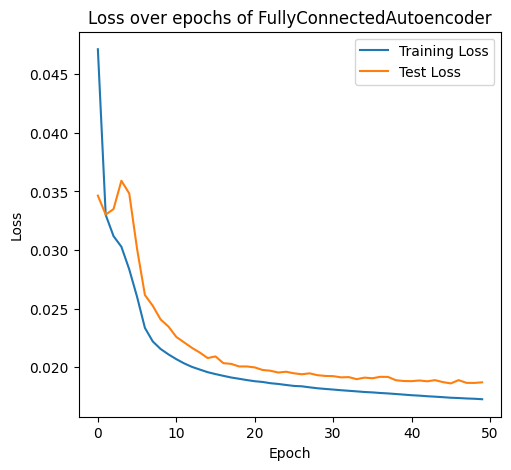

In [261]:
plt.figure(figsize=(12, 5))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title(f'Loss over epochs of {autoencoder.NAME}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### 七、应用于图像降噪
------

In [262]:
def rebuild_image(image):
    with torch.no_grad():
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device) / 255.
        output = autoencoder(image)
        return output.squeeze().cpu().numpy()  # 0-1 float类型灰度图

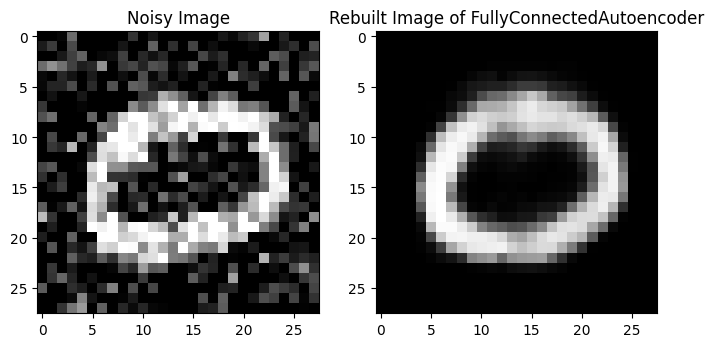

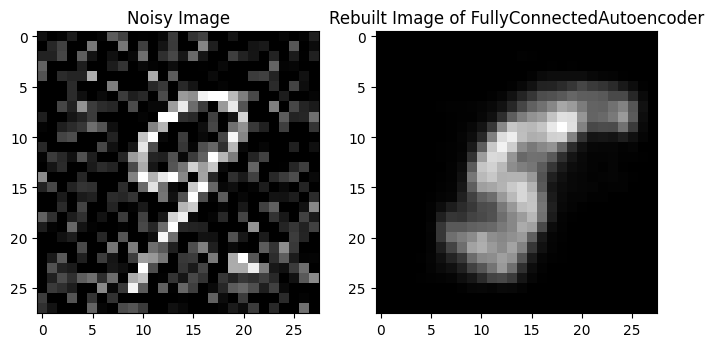

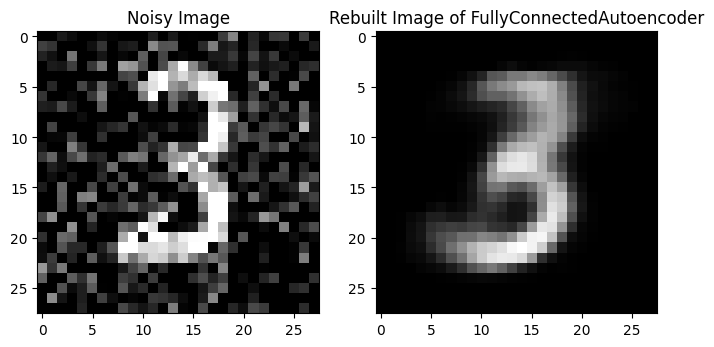

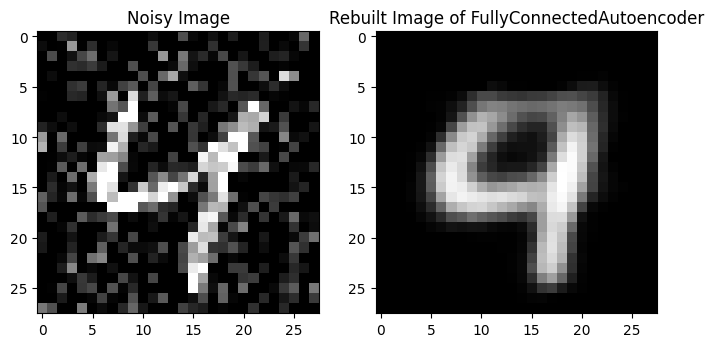

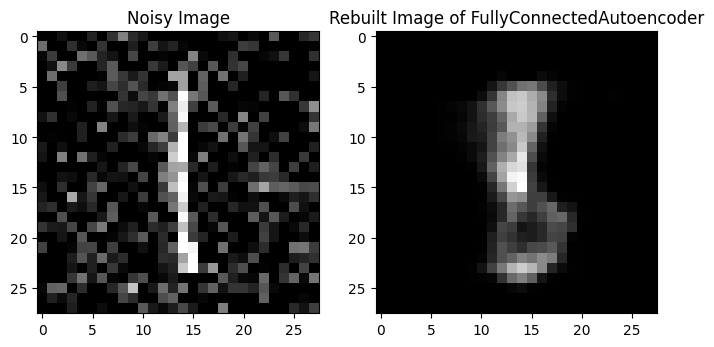

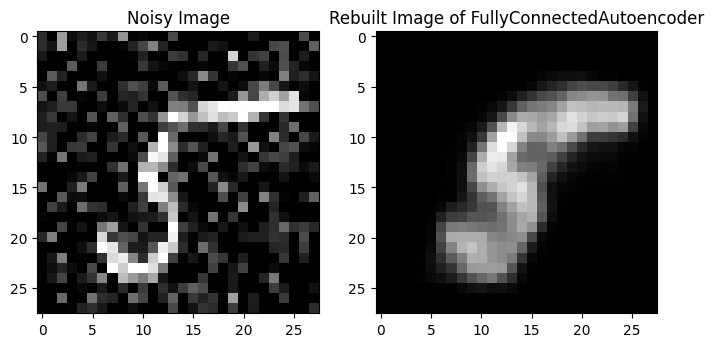

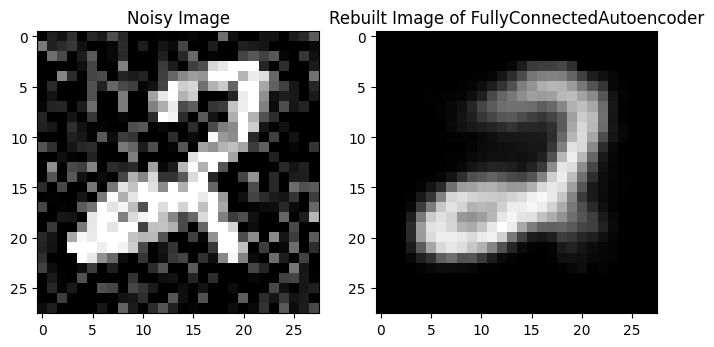

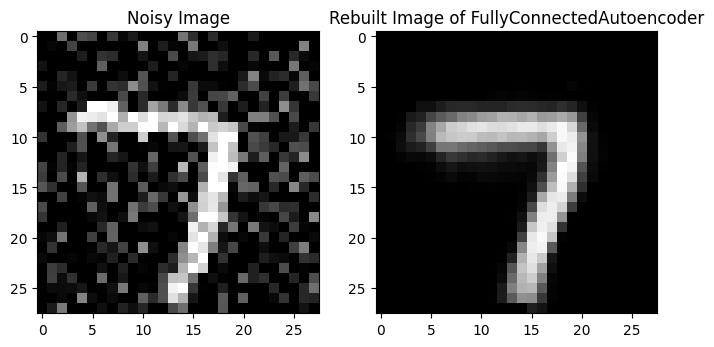

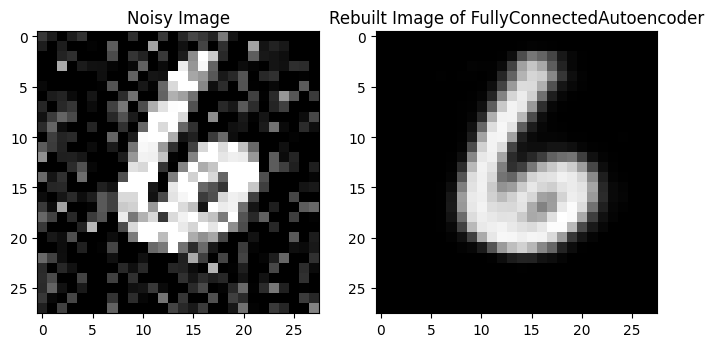

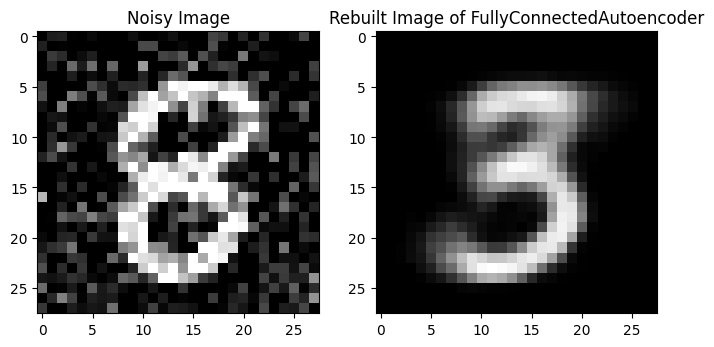

In [263]:
test_path = "testSample"
filepaths = []
# Walk through the dataset directory
for dir_path, dir_names, filenames in os.walk(test_path):
    for filename in filenames:
        filepath = os.path.join(dir_path, filename)
        filepaths.append(filepath)

for filepath in filepaths:
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    noisy_img = np.clip(np.random.normal(0, 60, image.shape).astype(int) + image, 0, 255)
    image_rebuild = rebuild_image(noisy_img)
    
    # 使用matplotlib显示图像
    plt.figure(figsize=(8, 4))

    # 显示带噪声的原始图像
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_img, cmap='gray')
    plt.title('Noisy Image')

    # 显示重建后的图像
    plt.subplot(1, 2, 2)
    plt.imshow(image_rebuild, cmap='gray')
    plt.title(f'Rebuilt Image of {autoencoder.NAME}')

    plt.show()